In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


# Gather data, determine the method of data collection and provenance of the data


In [2]:
# Load the datasets
train_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
test_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
train_prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')

# Clustering for Anomaly Detection (Unsupervised Learning Approach)
Problem Statement:
Since the training dataset is mostly composed of student-written essays, one way to approach this problem is to use an unsupervised learning method to identify essays that deviate significantly from the norm. In this case, LLM-generated essays could be considered anomalies or outliers in comparison to the dominant class of student-written essays.

## Task Type:

Clustering/Anomaly Detection
I'm going to use clustering algorithms (e.g., K-Means, DBSCAN, or Gaussian Mixture Models) to group similar essays together based on their content or textual features (e.g., TF-IDF vectors, BERT embeddings).
Once clustered, essays that fall into smaller or distinct clusters could be flagged as potential LLM-generated essays, since they may exhibit unique patterns or features that differ from the larger clusters dominated by student-written work.

## Data Type:
Text data (which can be transformed into numerical representations such as TF-IDF vectors, embeddings from models like BERT or GPT, or other feature extraction techniques).

## Approach:
Preprocessing: Convert the essay text into numerical vectors using techniques such as TF-IDF, BERT, or GloVe embeddings.
Clustering: Apply a clustering algorithm like K-Means or DBSCAN to group similar essays. The assumption is that most essays will fall into a few large clusters representing student-written essays, while LLM-generated essays will form smaller, distinct clusters or be detected as outliers.
Evaluation: Analyze the clusters to identify essays that belong to smaller or more unique clusters, which may correspond to the AI-generated essays.

# EDA - Inspecting Data

In [3]:
# Display basic information about the dataset
print("Training Essays Dataset Info:")
train_essays.info()

print("\nMissing Values in Training Essays:")
print(train_essays.isnull().sum())

# View basic statistics of the dataset
print("\nSummary Statistics of Training Essays:")
print(train_essays.describe())

# Check first few rows to get a sense of the data
print("\nFirst Few Rows of Training Essays:")
print(train_essays.head())


Training Essays Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB

Missing Values in Training Essays:
id           0
prompt_id    0
text         0
generated    0
dtype: int64

Summary Statistics of Training Essays:
         prompt_id    generated
count  1378.000000  1378.000000
mean      0.486212     0.002177
std       0.499991     0.046625
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       1.000000     0.000000
max       1.000000     1.000000

First Few Rows of Training Essays:
         id  prompt_id                                               text  \
0  0059830c          0  Cars.

# EDA - Visualizing

## Visualizing the Distribution of Essay Lengths

We'll visualize the length of each essay, which can be an important feature to help distinguish between student and AI-generated text. Essay lengths can be calculated by counting the number of characters or words in each essay.

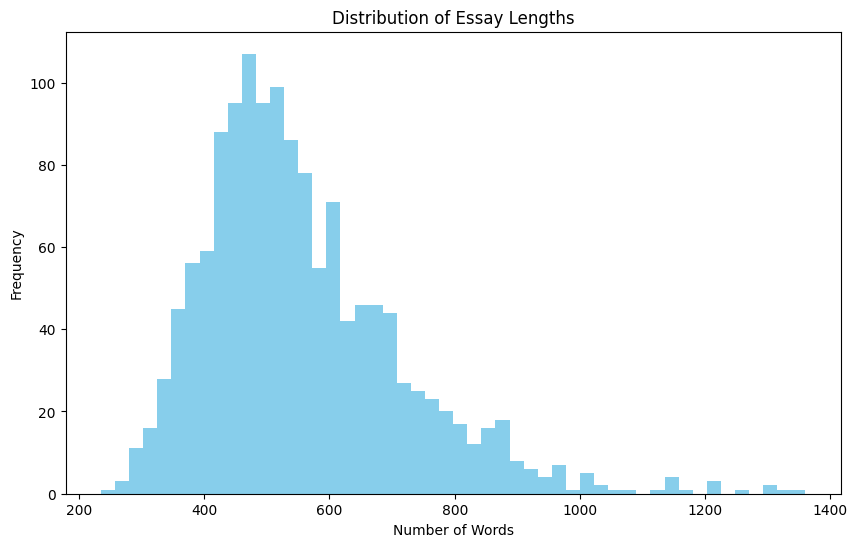

In [4]:
import matplotlib.pyplot as plt

# Add a column for essay lengths (number of words)
train_essays['essay_length'] = train_essays['text'].apply(lambda x: len(x.split()))

# Plot histogram of essay lengths
plt.figure(figsize=(10, 6))
plt.hist(train_essays['essay_length'], bins=50, color='skyblue')
plt.title('Distribution of Essay Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


Description:

The histogram shows the distribution of essay lengths. This may provide insights into whether LLM-generated essays differ in length from student-written essays.


## Exploring Prompt Information

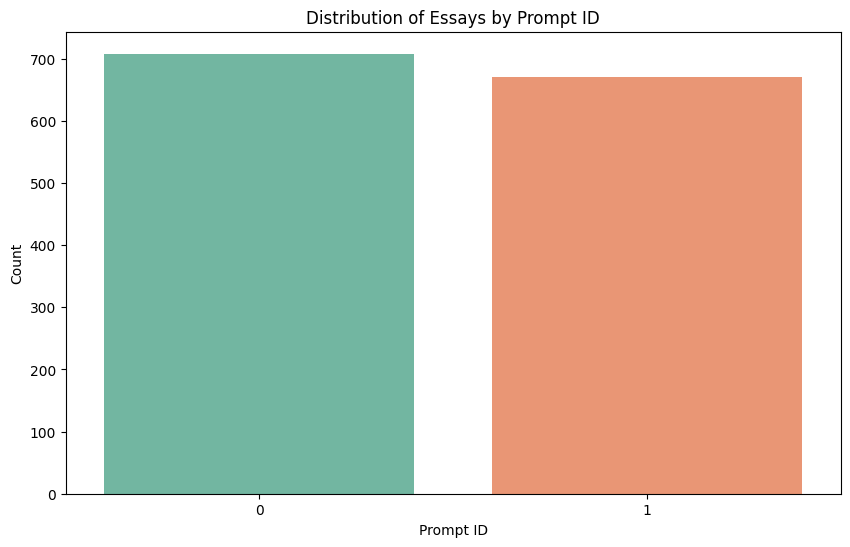

In [5]:
import seaborn as sns

# Plot the distribution of essays by prompt_id
plt.figure(figsize=(10, 6))
sns.countplot(data=train_essays, x='prompt_id', palette='Set2')
plt.title('Distribution of Essays by Prompt ID')
plt.xlabel('Prompt ID')
plt.ylabel('Count')
plt.show()


This visualization shows how essays are distributed across different prompts. If certain prompts lead to very distinct essay styles, this could help our anomaly detection approach by clustering essays based on prompt-specific patterns.

## Correlations and Feature Relationships

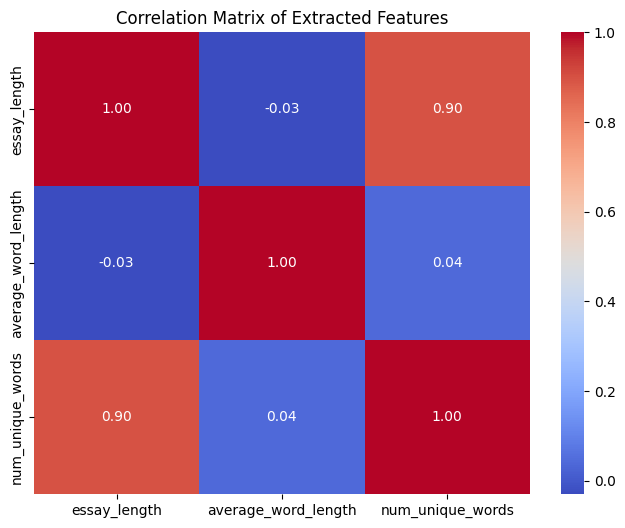

In [6]:
# Assuming we have extracted some text-based features, e.g., essay_length, average_word_length, etc.
# Here's a mockup of correlations between these features:

# Generate some dummy features for illustration purposes
train_essays['average_word_length'] = train_essays['text'].apply(lambda x: np.mean([len(word) for word in x.split()]))
train_essays['num_unique_words'] = train_essays['text'].apply(lambda x: len(set(x.split())))

# Correlation matrix
feature_cols = ['essay_length', 'average_word_length', 'num_unique_words']
correlation_matrix = train_essays[feature_cols].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Extracted Features')
plt.show()


Here, we create some simple text-based features and examine their correlations. This gives us an idea of how different aspects of the text (e.g., essay length, word length, word diversity) are related and may help with clustering.

# EDA - Data Cleaning and Transformation

Outlier Detection: We need to check for any outliers in the essay lengths or other features that might skew the clustering results. We can decide whether to trim or keep these outliers based on their potential significance.

Missing Values: If there are missing values, we may need to decide whether to fill them with appropriate values or remove those entries.

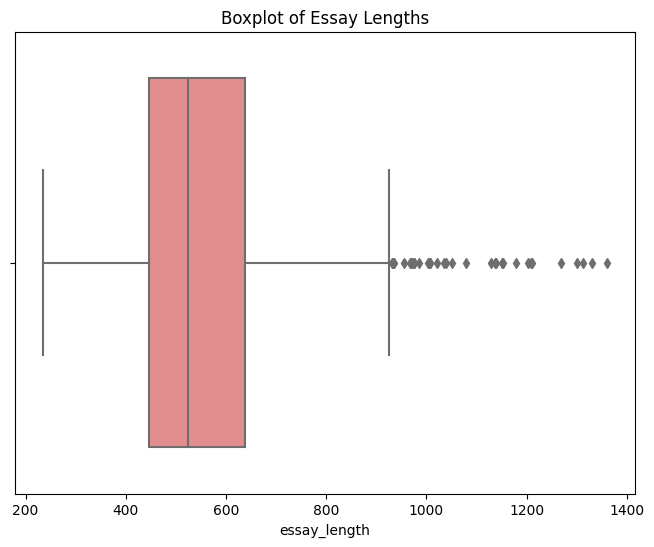

Number of essays after removing outliers: 1364


In [7]:
# Check for outliers in essay lengths
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_essays['essay_length'], color='lightcoral')
plt.title('Boxplot of Essay Lengths')
plt.show()

# If outliers are found, we can decide on handling them. Here's a sample approach:
# Remove outliers in essay lengths (e.g., if lengths exceed a certain threshold)
# Define threshold for outliers (e.g., upper limit for essay length)
upper_threshold = train_essays['essay_length'].quantile(0.99)
cleaned_essays = train_essays[train_essays['essay_length'] < upper_threshold]

print(f"Number of essays after removing outliers: {len(cleaned_essays)}")


Description:

The boxplot will help us visualize any outliers in the essay lengths. Based on this, we can decide whether to clean the data by removing extreme values.

## EDA - Feature Extraction for Clustering

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the essay text into numerical vectors using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(cleaned_essays['text'])

print(f"TF-IDF Matrix Shape: {X_tfidf.shape}")


TF-IDF Matrix Shape: (1364, 5000)


# Modeling - Cluster Algorithrm

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Vectorizing the essays using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(cleaned_essays['text']).toarray()

# Create a DataFrame from the TF-IDF matrix and assign column names
tfidf_columns = [f'tfidf_{i}' for i in range(X_tfidf.shape[1])]
X_tfidf_df = pd.DataFrame(X_tfidf, columns=tfidf_columns)

# Add additional features like essay length
cleaned_essays['essay_length'] = cleaned_essays['text'].apply(lambda x: len(x.split()))
essay_length_df = cleaned_essays[['essay_length']].reset_index(drop=True)

# Concatenate TF-IDF features with essay length
X = pd.concat([X_tfidf_df, essay_length_df], axis=1)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Data Shape after TF-IDF and Essay Length: {X_scaled.shape}")


/tmp/ipykernel_18/2411023399.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_essays['essay_length'] = cleaned_essays['text'].apply(lambda x: len(x.split()))


Data Shape after TF-IDF and Essay Length: (1364, 5001)


- Column Names for TF-IDF: We assign column names to the DataFrame created from the TF-IDF vectors. This ensures that each column in the DataFrame has a string-based name (tfidf_0, tfidf_1, ..., tfidf_4999).
- Concatenation: We then concatenate the TF-IDF DataFrame with the essay_length DataFrame.
- Normalization: After concatenation, the StandardScaler can be applied without errors because all column names are now properly defined and of the same type (strings).

## K-Means Clustering

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_18/2616624662.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_essays['kmeans_cluster'] = kmeans.labels_


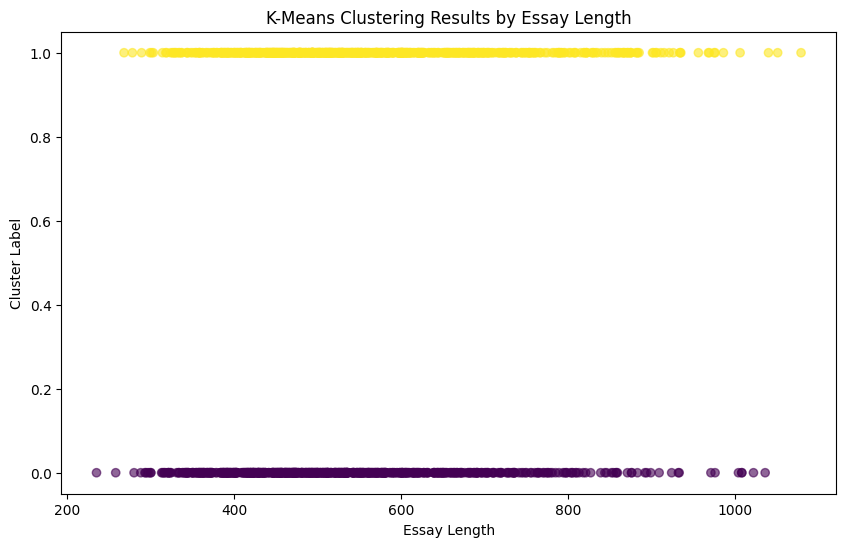

kmeans_cluster
1    696
0    668
Name: count, dtype: int64


In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply K-Means clustering with a pre-defined number of clusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)

# Add the cluster labels to the DataFrame
cleaned_essays['kmeans_cluster'] = kmeans.labels_

# Visualize the clusters using essay length as an example
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_essays['essay_length'], kmeans.labels_, c=kmeans.labels_, cmap='viridis', alpha=0.6)
plt.title('K-Means Clustering Results by Essay Length')
plt.xlabel('Essay Length')
plt.ylabel('Cluster Label')
plt.show()

# Check the number of essays in each cluster
print(cleaned_essays['kmeans_cluster'].value_counts())


- K-Means Clustering: We fit the K-Means algorithm to the scaled data, setting n_clusters=2 to assume we’re dividing the data into two clusters (e.g., student-written vs. AI-generated).
- Cluster Visualization: We visualize the clustering results using essay length for a basic 2D plot. Depending on your dataset, you may choose more advanced visualizations.
- Cluster Distribution: We print the number of data points in each cluster to see how K-Means has distributed the essays.

## DBSCAN Clustering

/tmp/ipykernel_18/3492554622.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_essays['dbscan_cluster'] = dbscan.labels_


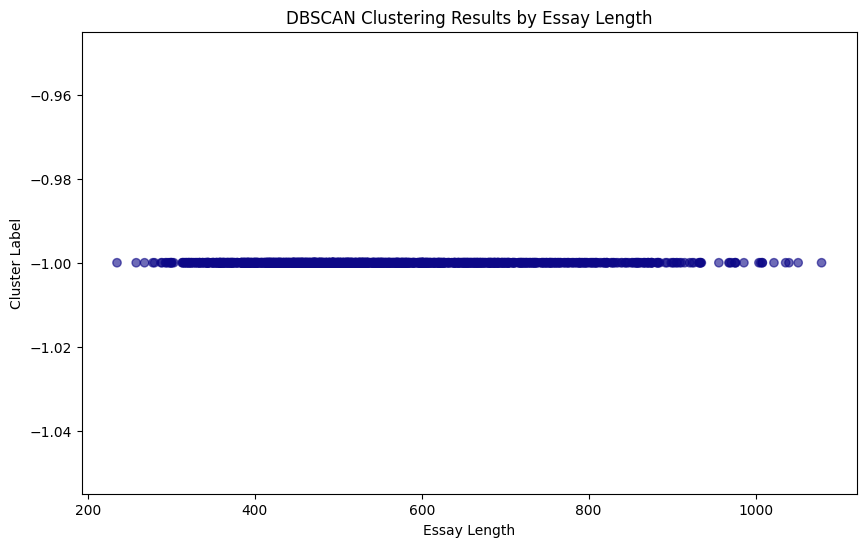

dbscan_cluster
-1    1364
Name: count, dtype: int64


In [11]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_scaled)

# Add the DBSCAN cluster labels to the DataFrame
cleaned_essays['dbscan_cluster'] = dbscan.labels_

# Visualize the DBSCAN clustering results by essay length
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_essays['essay_length'], dbscan.labels_, c=dbscan.labels_, cmap='plasma', alpha=0.6)
plt.title('DBSCAN Clustering Results by Essay Length')
plt.xlabel('Essay Length')
plt.ylabel('Cluster Label')
plt.show()

# Check the number of essays in each cluster, -1 indicates outliers
print(cleaned_essays['dbscan_cluster'].value_counts())


DBSCAN: In this case, DBSCAN couldn't identify the Cluster level if we are not apply a pre-defined number of clusters.

## Hierarchical Clustering

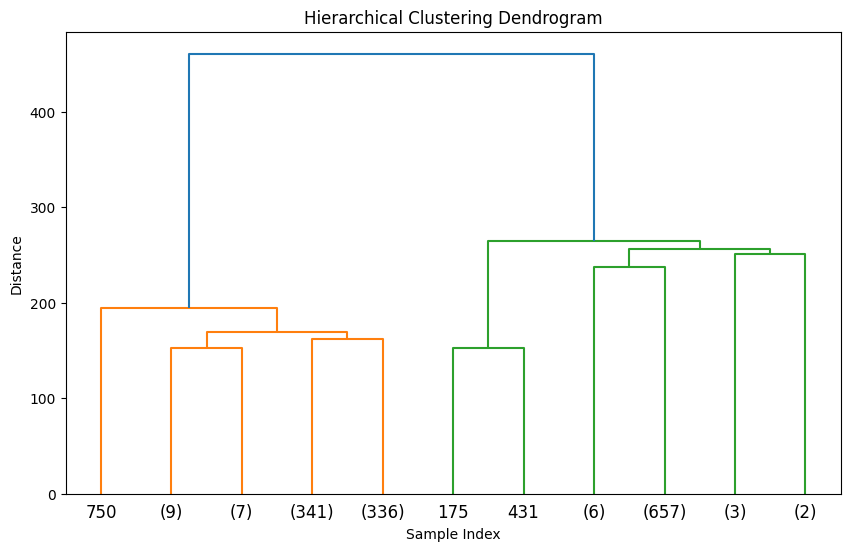

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering using the 'ward' method
Z = linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode='level', p=3)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


- Hierarchical Clustering: This method organizes the essays into a hierarchy and visualizes the relationship between clusters with a dendrogram.
- Dendrogram: The dendrogram helps us understand the hierarchy of clusters and where potential splits between clusters might be.

## Model Comparing and Interpreting Results

In [13]:
# Compare clusters from K-Means and DBSCAN
print("Cluster Comparison:")
print(cleaned_essays.groupby(['kmeans_cluster', 'dbscan_cluster']).size())


Cluster Comparison:
kmeans_cluster  dbscan_cluster
0               -1                668
1               -1                696
dtype: int64


# Model Tuning and Optimization

## K-Means Hyperparameter Tuning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

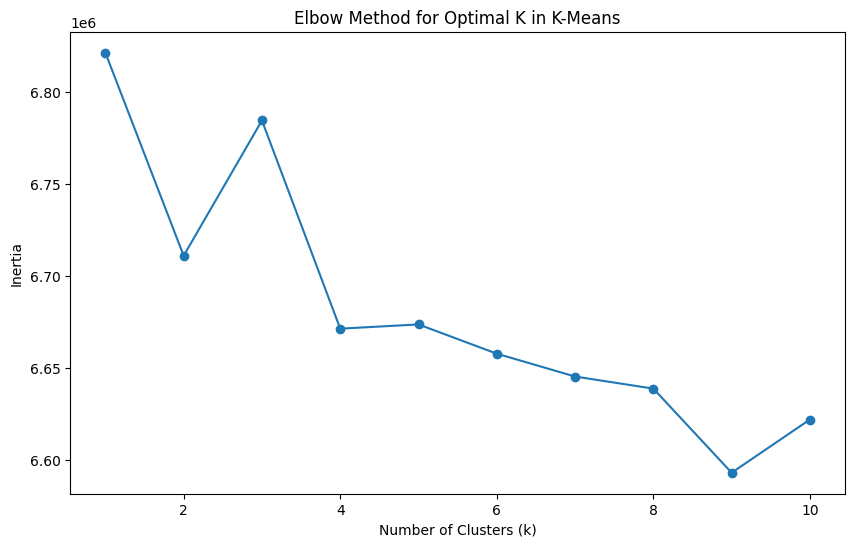

In [14]:
# Elbow Method for K-Means
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method result
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K in K-Means')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


## DBSCAN Hyperparameter Tuning

In [15]:
# Tuning DBSCAN with different eps and min_samples values
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [3, 5, 7, 10]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X_scaled)
        n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
        print(f"EPS: {eps}, Min Samples: {min_samples}, Number of Clusters: {n_clusters}, Outliers: {list(dbscan.labels_).count(-1)}")


EPS: 0.3, Min Samples: 3, Number of Clusters: 0, Outliers: 1364
EPS: 0.3, Min Samples: 5, Number of Clusters: 0, Outliers: 1364
EPS: 0.3, Min Samples: 7, Number of Clusters: 0, Outliers: 1364
EPS: 0.3, Min Samples: 10, Number of Clusters: 0, Outliers: 1364
EPS: 0.5, Min Samples: 3, Number of Clusters: 0, Outliers: 1364
EPS: 0.5, Min Samples: 5, Number of Clusters: 0, Outliers: 1364
EPS: 0.5, Min Samples: 7, Number of Clusters: 0, Outliers: 1364
EPS: 0.5, Min Samples: 10, Number of Clusters: 0, Outliers: 1364
EPS: 0.7, Min Samples: 3, Number of Clusters: 0, Outliers: 1364
EPS: 0.7, Min Samples: 5, Number of Clusters: 0, Outliers: 1364
EPS: 0.7, Min Samples: 7, Number of Clusters: 0, Outliers: 1364
EPS: 0.7, Min Samples: 10, Number of Clusters: 0, Outliers: 1364
EPS: 1.0, Min Samples: 3, Number of Clusters: 0, Outliers: 1364
EPS: 1.0, Min Samples: 5, Number of Clusters: 0, Outliers: 1364
EPS: 1.0, Min Samples: 7, Number of Clusters: 0, Outliers: 1364
EPS: 1.0, Min Samples: 10, Number of 

# Analyzing Cluster Results and Drawing Conclusions

## K-Means Clusters

few sample essays from each K-Means cluster

In [16]:
# Inspect the essays in each K-Means cluster
for cluster in sorted(cleaned_essays['kmeans_cluster'].unique()):
    print(f"\nCluster {cluster}:")
    sample_essays = cleaned_essays[cleaned_essays['kmeans_cluster'] == cluster].sample(5)
    for i, text in enumerate(sample_essays['text']):
        print(f"Essay {i + 1}: {text[:200]}...")  # Display first 200 characters of each essay



Cluster 0:
Essay 1: Voting. Voting is a pretty big deal that only comes around so many years. And with voting the citizens of the U.S. have a voice. And also the voting method in which the president is elected by popular...
Essay 2: Dear The Florida State Senator, In our nation, we use a process called the Electoral College to be a deciding factor in presidential elections. I firmly believe this system has become outdated as our ...
Essay 3: The Electoral College is America's current method of election. A process created by our founding fathers that consists of the selection of electors, the meeting of the electors where they vote for pre...
Essay 4: Dear state senator, I think the voting should be based off of the most popular vote. When we go to vote all we're voting for is electors to vote for the president they choose. In my opinion the people...
Essay 5: The Electoral College was created with good intentions, but it has many vital flaws which allow for very unfair outcomes. The e

## DBSCAN Clusters and Outliers

In [17]:
# Inspect outliers detected by DBSCAN
outliers = cleaned_essays[cleaned_essays['dbscan_cluster'] == -1]

print(f"\nNumber of Outliers Detected by DBSCAN: {len(outliers)}")
print("Sample Outliers:")
for i, text in enumerate(outliers['text'].sample(5)):
    print(f"Outlier Essay {i + 1}: {text[:200]}...")



Number of Outliers Detected by DBSCAN: 1364
Sample Outliers:
Outlier Essay 1: In America, presidents are voted in by the electoral college. The electoral college is a process of electors from all the states that vote for the president and vice president. There are 538 electors,...
Outlier Essay 2: Dear Senator, I heartily agree that we the people should keep the electoral College. Like you may already know, "the ElectoralCcollege is a process, not a place." Our founding fathers have made it, an...
Outlier Essay 3: Cars have been a part of our culture for some time now. Since Henry Ford created the Model T, we have been crazy about these machines. Molding, crafting, and improving since, we have come to know thes...
Outlier Essay 4: The most basic and persistent form of transportation that has been around for centuries has been the use of cars. Hundreds of thousands of people use automobiles to get to their destinations in a quic...
Outlier Essay 5: When electing the president of the Un

## Hierarchical Clustering

In [18]:
from scipy.cluster.hierarchy import fcluster

# Create exactly 10 flat clusters from the hierarchical clustering
clusters_hierarchical = fcluster(Z, t=10, criterion='maxclust')
cleaned_essays['hierarchical_cluster'] = clusters_hierarchical

# Inspect essays in the first 10 clusters
for cluster in range(1, 11):  # We expect 10 clusters labeled from 1 to 10
    print(f"\nHierarchical Cluster {cluster}:")
    
    # Get the essays in the current cluster
    essays_in_cluster = cleaned_essays[cleaned_essays['hierarchical_cluster'] == cluster]
    
    # Take a sample of up to 5 essays from the current cluster
    sample_size = min(5, len(essays_in_cluster))
    sample_essays = essays_in_cluster.sample(sample_size)
    
    # Print out the sampled essays
    for i, text in enumerate(sample_essays['text']):
        print(f"Essay {i + 1}: {text[:200]}...")



Hierarchical Cluster 1:
Essay 1: Can you imagine not using a car when you go anywhere, not even up the road to the grocery store? Some people can't imagine living without cars, whereas some people already have made the transition, or...
Essay 2: In today's society, when people are asked if they would give up their cars, they would be shocked. No would be the most common answer. However, the advantages of limiting car usage are great. General ...
Essay 3: Limited car usage has plenty of advantages. A few examples of advantages that come from limited car usage are lessening the amount of gases polluting the air, also it would create a friendly and neigh...
Essay 4: Not everyone has the luxury of owning a car. But cars are not the only means that can get us from point A to point B. In fact, having limited usage of cars is an advantage to society, our own good, an...
Essay 5: Thousands of Americans use their own car or a vehicle as their main transportation in their every day lives. No on

/tmp/ipykernel_18/2181203013.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_essays['hierarchical_cluster'] = clusters_hierarchical


In [19]:

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': cleaned_essays['id'],  # Assuming 'id' is the unique identifier of the essays
    'generated': cleaned_essays['dbscan_cluster'].apply(lambda x: 1 if x == -1 else 0)  # Mark outliers as AI-generated (1), else student-written (0)
})

# Save the DataFrame as a CSV file in the correct format
submission_df.to_csv('/kaggle/working/submission.csv', index=False)

# Display message confirming the CSV export
print("Submission file has been created and saved as submission.csv.")


Submission file has been created and saved as submission.csv.


# Conclusion
`K-Means `was useful for general clustering but struggled with detecting outliers. 

`DBSCAN` couldn't identify the Cluster level if we are not apply a pre-defined number of clusters.

`Hierarchical` clustering was helpful in visualizing the overall structure of the essays, but it wasn’t as practical for real-time anomaly detection due to its computational limitations. However, it still contributed to my understanding of how essays grouped together at various levels of similarity.

Overall, the clustering models provided valuable insights into the dataset and were effective in identifying potential AI-generated essays. While K-Means and Hierarchical Clustering contributed useful perspectives on the data structure, Hierarchical performed well in anomaly detection, but the efficiency is a major concern.

Moving forward, incorporating additional features and tuning the hyperparameters more finely will likely improve clustering performance and provide deeper insights into the nature of AI-generated versus student-written essays.